In [1]:
using Revise
using CMBLensing
using CMBLensing: @ntpack
using Random, Loess, Parameters, Random.DSFMT, Interpolations
using JLD2

┌ Info: Recompiling stale cache file /home/marius/.julia/compiled/v1.2/CMBLensing/niPeo.ji for CMBLensing [b60c06c0-7e54-11e8-3788-4bd722d65317]
└ @ Base loading.jl:1240
┌ Warning: Package CMBLensing does not have Setfield in its dependencies:
│ - If you have CMBLensing checked out for development and have
│   added Setfield as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CMBLensing
└ Loading Setfield into CMBLensing from project dependency, future warnings for CMBLensing are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [4]:
rfid = 0.1
Cℓ = camb(r=rfid);

In [25]:
@unpack f, f̃, ϕ, ds, ds₀ = load_sim_dataset(
    seed  = 0,
    rfid = rfid,
    Cℓ = Cℓ,
    θpix = 3,
    Nside = 256,
    use = :P,
    T = Float32,
    μKarcminT = 10/√2,
)
@unpack Cf, Cϕ = ds₀;

In [26]:
# mixing matrices
σ²len=deg2rad(5/60)^2
Nϕ = nan2zero.(ϕqe(ds₀)[2])/2
ds = DataSet(ds,
    G = ParamDependentOp(let SN=Cϕ/Nϕ, G₀=sqrt(1+2/SN)
        (;Aϕ=1, _...)-> @. sqrt(1+2/(Aϕ*SN))/G₀
    end),
    D = (@. nan2zero(sqrt(1 + 2/(Cf/(ds.Cn̂+σ²len))))),
);

In [27]:
sample_joint(
    ds,
    Cℓ = Cℓ,
    θrange = (Aϕ=range(0.5, 1.9, length=25),),
    θstart = (Aϕ=1,),
    symp_kwargs = (N=25, ϵ=0.02),
    nsamps_per_chain = 10,
    nchains = 1, 
    pmap = map,
    nchunk = 2,
    nsavemaps = 10,
    nburnin_always_accept = Inf,
    nburnin_fixθ = 0,
    metadata = (@ntpack f f̃ ϕ ds₀),
    progress = :summary,
    filename = "testchain.jld2"
);

Gibbs chain: 100%|██████████████████████████████████████| Time: 0:05:22


In [28]:
@load "testchain.jld2" 

2-element Array{Symbol,1}:
 :chains
 :rundat

In [29]:
using Statistics

In [30]:
getindex.(chains[1][2:end],:timing)

10-element Array{NamedTuple{(:f, :θ, :ϕ),Tuple{Float64,Float64,Float64}},1}:
 (f = 3.115016167, θ = 8.954657676, ϕ = 27.103998331) 
 (f = 0.96117215, θ = 9.723460596, ϕ = 20.927602568)  
 (f = 0.716426248, θ = 9.267559107, ϕ = 19.746085108) 
 (f = 0.634769225, θ = 8.661115741, ϕ = 19.175055979) 
 (f = 0.62653508, θ = 8.689044008, ϕ = 20.336935978)  
 (f = 1.265916839, θ = 10.242237773, ϕ = 19.286341166)
 (f = 1.010267911, θ = 9.267745122, ϕ = 20.404541676) 
 (f = 0.835300153, θ = 8.484976122, ϕ = 22.227946742) 
 (f = 0.647691704, θ = 8.461052793, ϕ = 22.776909722) 
 (f = 0.578629753, θ = 8.642342834, ϕ = 21.026899381) 

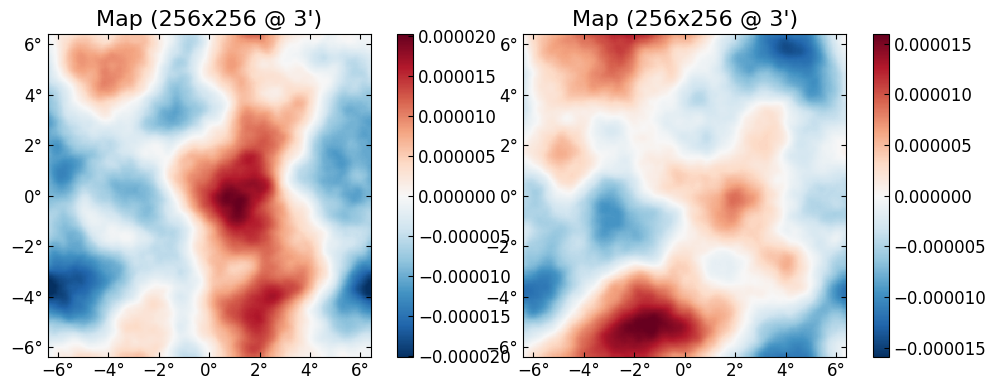

(PyPlot.Figure(PyObject <Figure size 1120x400 with 4 Axes>), PyCall.PyObject[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f6cb1b65080> PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f6cb1b24908>], Symbol[:Tx])

In [31]:
plot([rundat[:metadata].ϕ mean(getindex.(filter(s->haskey(s,:ϕ),chains[1]),:ϕ))])

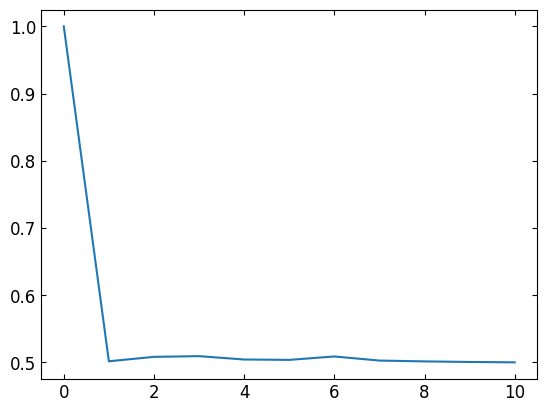

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6c96fe71d0>

In [33]:
plot(first.(getindex.(chains[1],:θ)))